In [275]:
down_sample <- TRUE

In [276]:
options(warn = -1)  # Suppress warnings globally if needed

Training set cells: 40000 
Test set cells: 10000 


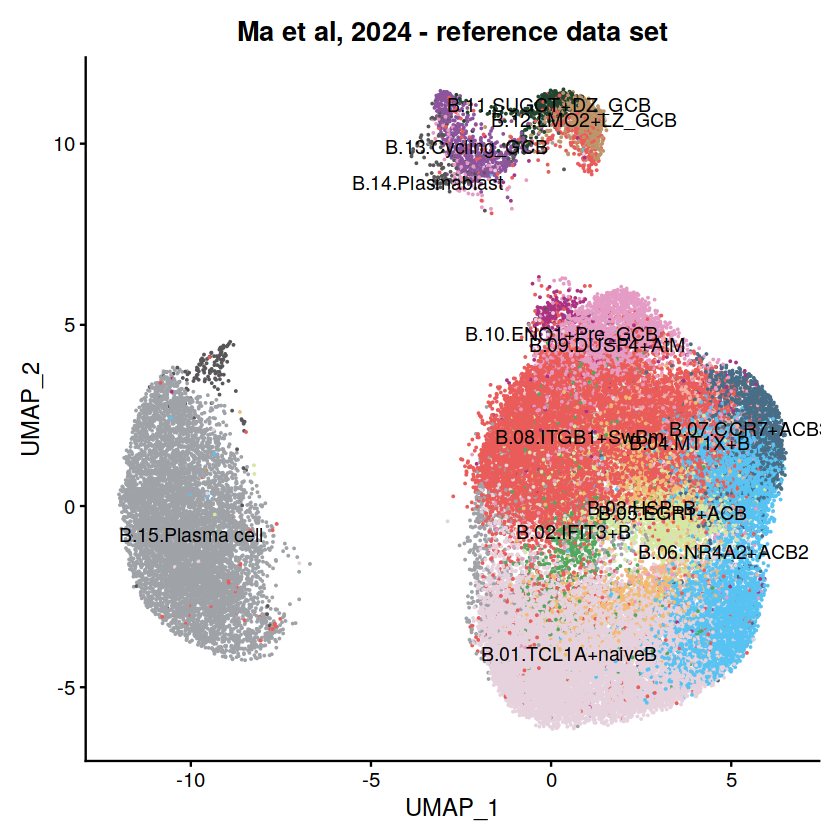

In [291]:
# Load required libraries
library(Seurat)     # For single-cell RNA-seq analysis and visualization
library(dplyr)      # For data manipulation (e.g., piping and transforming data)
library(gridExtra)  # For arranging multiple plots in a grid
library(ggplot2)    # For creating and customizing plots (ggtitle comes from ggplot2)
library(future)     # For parallel processing to improve computational efficiency


# Set the random seed for reproducibility
set.seed(42)

calculate_cosine_similarity <- function(matrix, vector) {
  
  # Normalize the vector
  vector_norm <- sqrt(sum(vector^2))
  vector_normalized <- vector / vector_norm
  
  # Initialize a vector to store cosine similarities for each column
  cosine_similarities <- numeric(ncol(matrix))
  
  # Loop through each column in the matrix and calculate cosine similarity
  for (i in 1:ncol(matrix)) {
    
    # Get the column
    column <- matrix[, i]
    
    # Normalize the column
    column_norm <- sqrt(sum(column^2))
    column_normalized <- column / column_norm
    
    # Calculate cosine similarity as dot product of normalized vectors
    cosine_similarities[i] <- sum(column_normalized * vector_normalized)
  }
  
  return(cosine_similarities)
}

# Set maximum global memory size to 30 GB for future operations (e.g., large data objects)
options(future.globals.maxSize = 50 * 1024^3)  # 100 GiB limit for globals

# Set up parallel processing with 2 workers/cores to speed up computations
#plan("multicore", workers = 1)  # Reduce the number of cores to 2 to reduce memory usage
future::plan("sequential")

# Define the path to the reference dataset (processed single-cell RNA-seq data)
# The reference data is from a public repository and stored locally
ref_data_dir <- paste0(getwd(), '/references/zenodo.11468564/scRNA_data/panB_scRNA_processed_data.rds')

# Load the reference dataset from the specified directory (single-cell RNA-seq data)
ref_data <- readRDS(ref_data_dir)

# subset the data to improve performance
if(down_sample == TRUE) {
    # sample visium data set to speed up during testing phase
    subset_cells <- sample(Cells(ref_data), 50000)  # Subset 10000 random cells
    ref_data <- subset(ref_data, cells = subset_cells)
    }

# Get the cell names (barcodes) in the Seurat object
cell_names <- colnames(ref_data)

# Split the cells randomly into training and test sets
# Let's assume we want 80% for the training set and 20% for the test set
train_cells <- sample(cell_names, size = floor(0.8 * length(cell_names)), replace = FALSE)
test_cells <- setdiff(cell_names, train_cells)

# Subset the Seurat object into training and test sets
ref_train <- subset(ref_data, cells = train_cells)
ref_test <- subset(ref_data, cells = test_cells)

# Print the number of cells in each set to verify
cat("Training set cells:", ncol(ref_train), "\n")
cat("Test set cells:", ncol(ref_test), "\n")

# Define a custom color palette with 36 colors for visualizing different cell types
# This will help differentiate the cell types in the UMAP plot
my36colors <- c('#E5D2DD', '#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87',
                '#E95C59', '#E59CC4', '#AB3282', '#23452F', '#BD956A', '#8C549C', '#585658',
                '#9FA3A8', '#E0D4CA', '#5F3D69', '#C5DEBA', '#58A4C3', '#E4C755', '#F7F398',
                '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', '#B53E2B',
                '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963',
                '#968175')

# Create the first UMAP plot (before SCTransform) with a title
# This plot visualizes the data before any normalization (SCTransform) has been applied
p1 <- DimPlot(ref_data, group.by = "celltype", label = TRUE, cols = my36colors) + 
  NoLegend() +                          # Remove the legend for clearer visualization
  ggtitle("Ma et al, 2024 - reference data set")         # Add a title to the plot

p1

In [292]:
# ## import the seurat processed data
visium_path <- paste0(getwd(), '/objects/seurat_objects.rds')
visium_merge <- readRDS(visium_path)

if(down_sample == TRUE) {
    # sample visium data set to speed up during testing phase
    subset_cells <- sample(Cells(visium_merge), 1000)  # Subset 10000 random cells
    visium_merge <- subset(visium_merge, cells = subset_cells)
    }

In [322]:
#get the variable features
ref_train <- FindVariableFeatures(ref_train, selection.method = "dispersion", nfeatures = 3000)
ref_features <- VariableFeatures(ref_train)

In [323]:
visium_matrix <-GetAssayData(visium_merge, assay = "SCT", slot = "data")

## generate a psuedobulk dataframe where the rows are the HVGs and the columns are cell type
pseudo_b_ref <- AggregateExpression(ref_train, features = ref_features, assays = "RNA", slot = 'data',return.seurat = T, group.by = "celltype")
pseudo_bulk_matrix <- GetAssayData(pseudo_b_ref, assay = "RNA", slot = "data")

overlapping_genes <- intersect(rownames(visium_matrix),rownames(pseudo_bulk_matrix))

print(length(overlapping_genes))  # will need to expand the number genes for the SCT transformation

## subset the matrices
visium_matrix <- visium_matrix[overlapping_genes,]
pseudo_bulk_matrix <- pseudo_bulk_matrix[overlapping_genes,]

# grab the expression matrix for the test set as well
ref_test_matrix <- GetAssayData(ref_test, assay = "RNA", slot = "data")
ref_test_matrix <- ref_test_matrix[overlapping_genes,]

Centering and scaling data matrix



[1] 1741


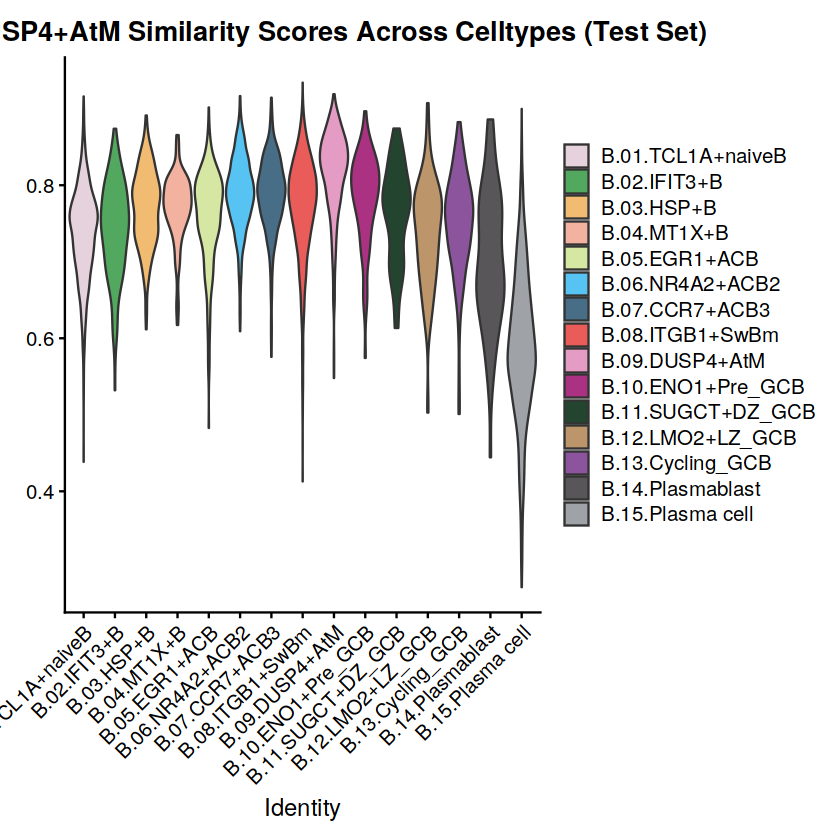

In [324]:
# plot the cosine similarities across differing cell types in the test set

# cor_values <- apply(b_ref_matrix_overlap, 2, function(column) cor(dn_b, column, method = 'pearson'))
# print(cor_values)

dnbcell_name <- 'B.09.DUSP4+AtM'

dn_b <- pseudo_bulk_matrix[,dnbcell_name] 
dn_b_cell_cos <- calculate_cosine_similarity(ref_test_matrix,dn_b)
ref_test[[dnbcell_name]] <- dn_b_cell_cos
Idents(ref_test) <- 'celltype'
sorting_order <- sort(unique(ref_test$celltype))
ref_test$celltype <- factor(ref_test$celltype, levels = sorting_order)
vp <- VlnPlot(ref_test,features = dnbcell_name, cols = my36colors, pt.size = 0)
vp + ggtitle("B.09.DUSP4+AtM Similarity Scores Across Celltypes (Test Set)")


Call:
glm(formula = cell_identity ~ ., family = "binomial", data = train_data)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.0519     0.1730 -17.646   <2e-16 ***
B.09.DUSP4.AtM   0.2891     0.2321   1.246    0.213    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 17101  on 39999  degrees of freedom
Residual deviance: 17100  on 39998  degrees of freedom
AIC: 17104

Number of Fisher Scoring iterations: 5


Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



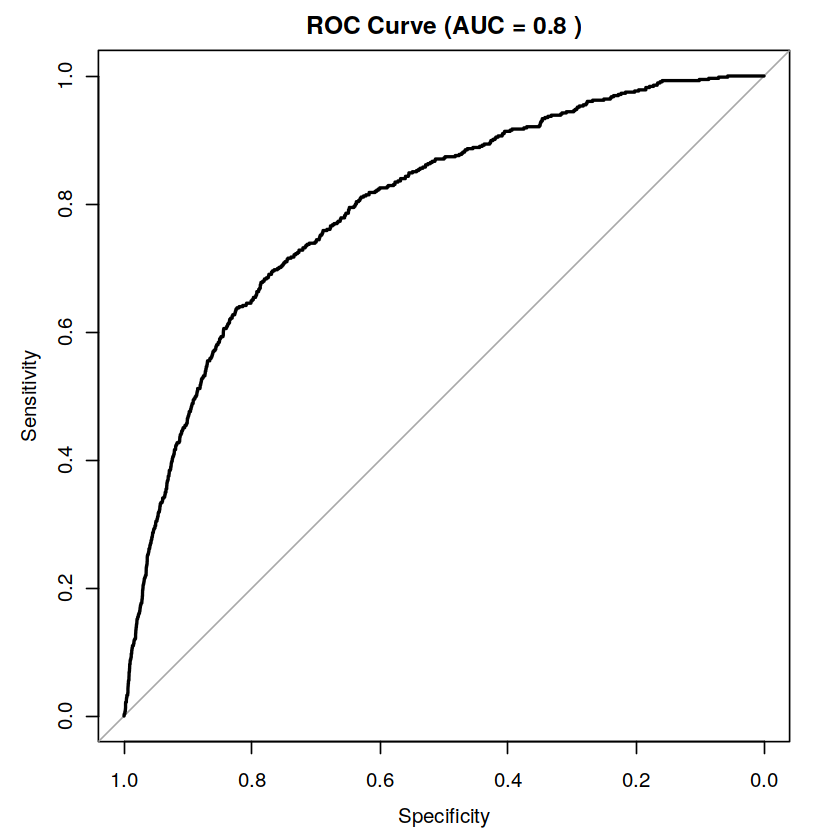

In [325]:
# validating the accuracy of the cosine similarity metric
ref_train_matrix <- GetAssayData(ref_train, assay = "RNA", slot = "data")
ref_train_matrix <- ref_test_matrix[overlapping_genes,]
dn_b_cell_cos <- calculate_cosine_similarity(ref_train_matrix,dn_b)
ref_train[[dnbcell_name]] <- dn_b_cell_cos
train_cell_ids <- as.factor(ref_train[['celltype']]  == "B.09.DUSP4+AtM")
test_cell_ids <- as.factor(ref_test[['celltype']]  == "B.09.DUSP4+AtM")
train_cosine_scores <- as.list(ref_train[[dnbcell_name]])
test_cosine_scores <- as.list(ref_test[[dnbcell_name]])
train_data <- data.frame(train_cosine_scores)
train_data$cell_identity <- train_cell_ids
model <- glm(cell_identity ~ ., data = train_data, family = "binomial")
summary(model)
test_data <- data.frame(test_cosine_scores)
pred_probs <- predict(model, test_data, type = "response")
library(pROC)
roc_curve <- roc(test_cell_ids, pred_probs)  # test_cell_ids is the true outcome for the test set
auc_value <- auc(roc_curve)
plot(roc_curve, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"))

In [333]:
# calculate cosine similarity scores for each cell type
for (type in colnames(pseudo_bulk_matrix)){
    current_ref <- pseudo_bulk_matrix[,type]
    current_cos <- calculate_cosine_similarity(visium_matrix,current_ref)
    visium_merge[[type]] <- current_cos
}

In [334]:
# subset to pre and post
pre <- subset(visium_merge, subset = sample %in% c('PRE-01','PRE-02','PRE-04','PRE-05'))
post <- subset(visium_merge, subset = sample %in% c('POST-03','POST-05','POST-06','POST-11'))

In [329]:
# # generate a funciton that calculates the similarity scores for all of the cell types and then execute

# dn_b <- pseudo_bulk_matrix[,'B.09.DUSP4+AtM'] 
# dn_b_cell_cos <- calculate_cosine_similarity(visium_matrix,dn_b)
# visium_merge$dn_b_cos <- dn_b_cell_cos

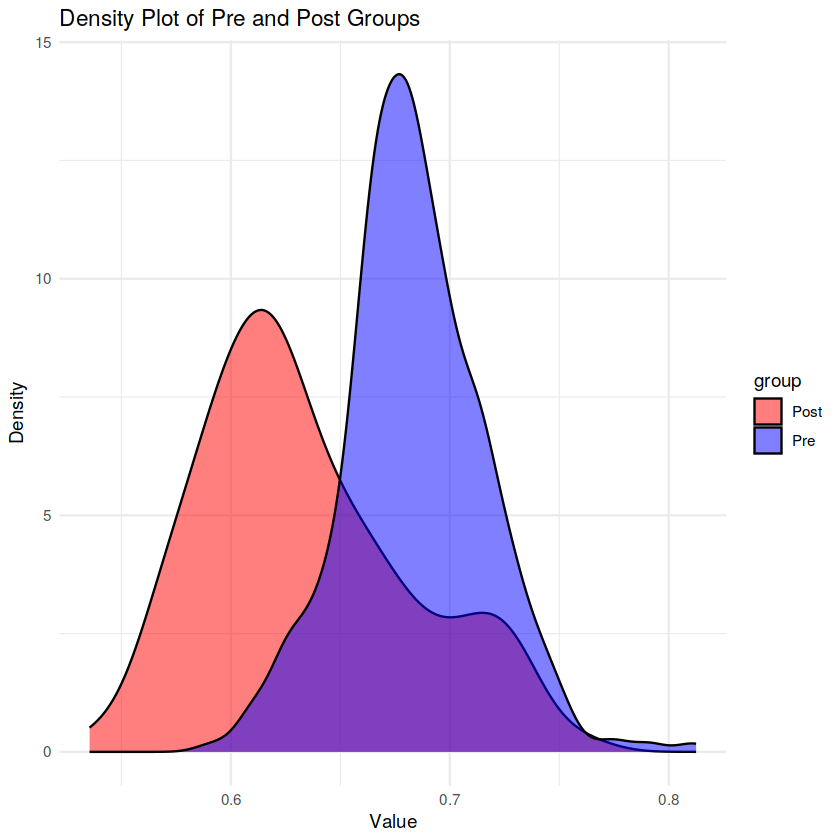

In [344]:
# Just examine the dominant negative b cell subtype

current_type <- 'B.09.DUSP4+AtM'

pre_data <- pre[[current_type]]
post_data <- post[[current_type]]

df <- data.frame(value = rbind(pre_data, post_data),
                group = factor(c(rep("Pre", length(unlist(pre_data))),rep("Post", length(unlist(post_data))))))

colnames(df)[1] <- "value"

# # Plot with ggplot
dist_plot <- ggplot(df, aes(x = value, fill = group)) + 
geom_density(alpha = 0.5) + 
labs(title = "Density Plot of Pre and Post Groups", x = "Value", y = "Density") +
scale_fill_manual(values = c("red", "blue")) +
theme_minimal()

dist_plot

In [339]:
# function that calculates the earth mover's distance and p value for every single cos sim metric
# all are added to a dataframe for later plotting

# Load the transport package
library(transport)

# Initialize an empty data frame
results_df <- data.frame(
  cell_type = character(),       # For cell type names (character column)
  earth_movers_distance = numeric(),  # For EMD values (numeric column)
  p_value = numeric(),           # For p-values (numeric column)
  stringsAsFactors = FALSE       # Prevent strings from being factors
)

for (type in colnames(pseudo_bulk_matrix)){

pre_data <- pre[[type]]
post_data <- post[[type]]

vector1 <- as.numeric(unlist(pre_data))  # Flatten and convert pre_data
vector2 <- as.numeric(unlist(post_data)) # Flatten and convert post_data

# Compute the observed EMD
emd_obs <- wasserstein1d(vector1, vector2)

# Combine the two datasets
combined_data <- c(vector1, vector2)

# Number of permutations
n_permutations <- 1000
emd_permutations <- numeric(n_permutations)

# Perform permutation test
for (i in 1:n_permutations) {
  # Resample the combined data to create two new groups (same size as original)
  resampled_groups <- sample(combined_data, length(vector1))  # Resample for the "pre" group
  resampled_post <- setdiff(combined_data, resampled_groups)  # The remaining data is the "post" group
  
  # Compute the EMD with resampled data
  emd_permutations[i] <- wasserstein1d(resampled_groups, resampled_post)
}

# Calculate p-value (proportion of permuted EMDs greater than observed EMD)
p_val <- mean(emd_permutations >= emd_obs)

results_df <- rbind(results_df, data.frame(
cell_type = type,
earth_movers_distance = emd_obs,
p_value = p_val))
}

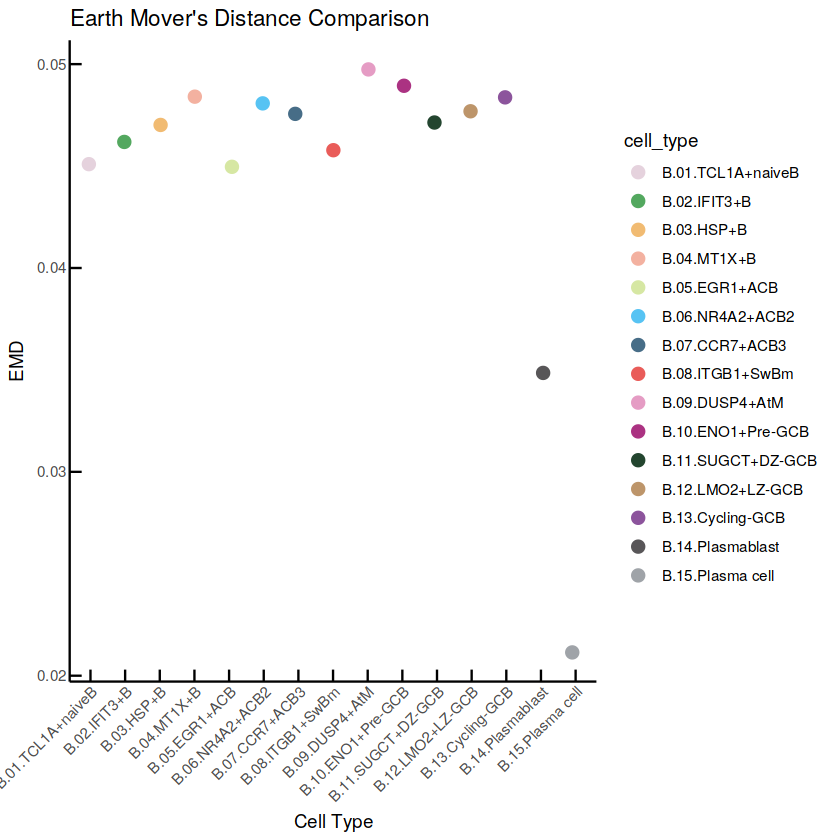

In [365]:
# Example ggplot with your color palette
ggplot(results_df, aes(x = cell_type, y = earth_movers_distance, color = cell_type)) +
  geom_point(position = position_jitter(width = 0.1, height = 0), size = 3) +
  labs(title = "Earth Mover's Distance Comparison", 
       x = "Cell Type", 
       y = "EMD") +
  scale_color_manual(values = my36colors) +  # Apply custom color palette
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "black"),
    panel.border = element_blank(),
    axis.ticks = element_line(color = "black"),
    axis.ticks.length = unit(-0.1, "inches")
  )